In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit

In [69]:
import numpy as np
import sys
sys.path.append('/Users/lkbayne/Desktop/python/tools')
import chem_calcs as cc

In [70]:
#importing my file as it comes out of the pFI program
file = 'Day_0.txt'

df = pd.read_csv(file, sep="\t", engine='python')

In [71]:
#filtering for only the sample name, and the needed absorbances
filtered_df = df[['Name', 'AVE810_1050', 'AVE880_1050']]

In [72]:
c1 = 4997.89 #PO4 concentration [uM]
v1 = 40 #spike [uL]
c2 = None
v2 = 50*1000 #250 mL bottle in uL
PO4_conc = cc.conc_to_dil(c1, v1, c2, v2)
print(PO4_conc)
c1 = 10255 #Si concentration [uM]
v1 = 220 #spike [uL]
c2 = None
v2 = 50*1000 #250 mL bottle in uL
Si_conc = cc.conc_to_dil(c1, v1, c2, v2)
print(Si_conc)

3.9983120000000003
45.122


In [73]:
#calibration curve dilution values
dil_0 = 0
dil_1 = (600-450)/600
dil_2 = (600-300)/600
dil_3 = (600-150)/600
dil_4 = (600-50)/600
Si_cali_concs = np.array([dil_0, dil_0, dil_0, dil_1, dil_1, dil_1, dil_2, dil_2, dil_2, dil_3, dil_3, dil_3, dil_4, dil_4, dil_4]) * Si_conc
PO4_cali_concs = np.array([dil_0, dil_0, dil_0, dil_1, dil_1, dil_1, dil_2, dil_2, dil_2, dil_3, dil_3, dil_3, dil_4, dil_4, dil_4]) * PO4_conc

In [74]:
#absorbances
Si_cali_abs = filtered_df.loc[filtered_df['Name'].str.contains("Calibration Si", case=False), 'AVE810_1050'].to_numpy()
PO4_cali_abs = filtered_df.loc[filtered_df['Name'].str.contains("Calibration PO4", case=False), 'AVE880_1050'].to_numpy()

In [75]:
#calibration curves
Si_cali_curve = stats.linregress(Si_cali_concs, Si_cali_abs)
PO4_cali_curve = np.polyfit(PO4_cali_concs, PO4_cali_abs, 2)

In [76]:
#slopes and y-intercepts to use in calculations
Si_slope = Si_cali_curve.slope
print('Si Slope=', Si_slope)
Si_yint = Si_cali_curve.intercept
print('Si y-intercept=', Si_yint)

Si_slope_err = Si_cali_curve.stderr
Si_yint_err = Si_cali_curve.intercept_stderr

a = PO4_cali_curve[0]
print('a=', a)
b = PO4_cali_curve[1]
print('b=', b)
c = PO4_cali_curve[2]
print('c=', c)

Si Slope= 0.025511181304965196
Si y-intercept= 0.0011247639593910952
a= 0.006199838672668264
b= 0.03598072180416947
c= -0.022751083502973717


In [77]:
#Predict absorbances from Si calibration curve
Si_predicted_abs = Si_slope * np.array(Si_cali_concs) + Si_yint

#Residuals: observed - predicted
Si_residuals = np.array(Si_cali_abs) - Si_predicted_abs

#Sxo for Si
n_Si = len(Si_cali_concs)  #number of calibration points
Sxo_Si = np.sqrt(np.sum(Si_residuals**2) / (n_Si - 2))  #for linear n - 2

print('Sxo_Si =', Sxo_Si)

#Predict absorbances from PO4 quadratic curve
PO4_predicted_abs = a * np.array(PO4_cali_concs)**2 + b * np.array(PO4_cali_concs) + c

#Residuals: observed - predicted
PO4_residuals = np.array(PO4_cali_abs) - PO4_predicted_abs

#Calculate Sxo for PO4
n_PO4 = len(PO4_cali_concs)  #number of calibration points
Sxo_PO4 = np.sqrt(np.sum(PO4_residuals**2) / (n_PO4 - 3))  #for quadratic n - 3

print('Sxo_PO4 =', Sxo_PO4)

Sxo_Si = 0.013902124672591347
Sxo_PO4 = 0.004284328966825244


Text(0.5, 0, 'Absorbance 810-1050')

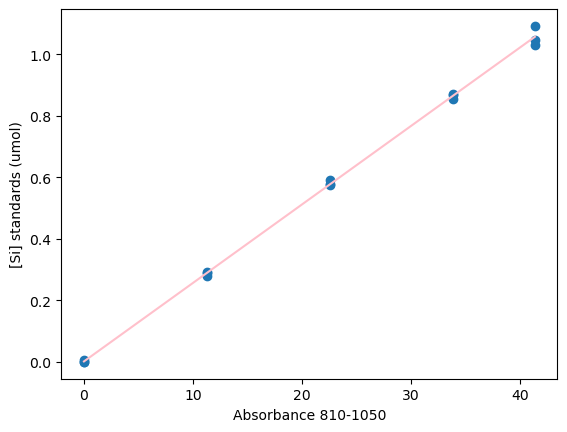

In [78]:
#plotting the Si calibration curve
plt.figure()
plt.scatter(Si_cali_concs, Si_cali_abs)
plt.plot(Si_cali_concs, Si_cali_curve.slope * Si_cali_concs + Si_cali_curve.intercept, color='Pink')
plt.ylabel('[Si] standards (umol)')
plt.xlabel('Absorbance 810-1050')

Text(0.5, 0, 'Absorbance 880-1050')

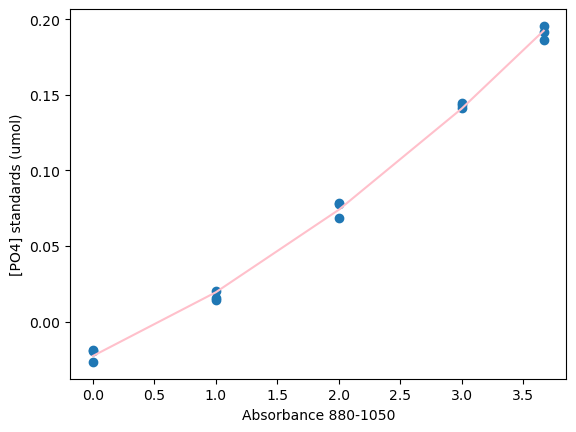

In [79]:
#plotting the PO4 calibration curve
plt.figure()
plt.scatter(PO4_cali_concs, PO4_cali_abs)
PO4_reg = a * PO4_cali_concs**2 + b * PO4_cali_concs + c
plt.plot(PO4_cali_concs, PO4_reg, color='pink')
plt.ylabel('[PO4] standards (umol)')
plt.xlabel('Absorbance 880-1050')

In [80]:
results = []

Si_samples = ["A2", "A3", "A4", "B2", "B3", "B4", "C2", "C3", "C4", "D1", "D2"]

P_samples = ["A1_P", "A3_P", "A4_P", "B1_P", "B3_P", "B4_P", "C1_P", "C3_P", "C4-P", "D1_P", "D2_P"]

#fix names
Si_samples = [sample + "_Si" for sample in Si_samples]
P_samples = [sample.replace("-P", "_PO4").replace("_P", "_PO4") for sample in P_samples]


#Si
for sample in Si_samples:
    avg_abs = filtered_df.loc[filtered_df['Name'].str.contains(sample, case=False), 'AVE810_1050'].mean()
    conc, u_combined = cc.calc_Si_conc_and_uncert(
        avg_abs,
        Si_yint,
        Si_slope,
        Sxo_Si,
        Si_slope_err,
        Si_yint_err
    )
    results.append({
        'Sample': sample,
        'Day': 0,
        'Concentration_μmol': conc,
        'u_combined_μmol': u_combined
    })

#PO4
for sample in P_samples:
    avg_abs = filtered_df.loc[filtered_df['Name'].str.contains(sample, case=False), 'AVE880_1050'].mean()
    conc, u_combined = cc.calc_PO4_conc_and_uncert(
        avg_abs,
        a,
        b,
        c,
        Sxo_PO4
    )
    results.append({
        'Sample': sample,
        'Day': 0,
        'Concentration_μmol': conc,
        'u_combined_μmol': u_combined
    })

processed_df = pd.read_csv('processed_concentrations.csv')
updated_df = pd.concat([processed_df, pd.DataFrame(results)], ignore_index=True)
updated_df.to_csv('processed_concentrations.csv', index=False)

results = []

pivot_df = updated_df.pivot_table(
    index='Sample', 
    columns='Day', 
    values='Concentration_μmol'
).reset_index()

pivot_df.columns.name = None

display(pivot_df)

,Sample,35
0,A1_PO4,1.949597
1,A2_Si,41.712118
2,A3_PO4,2.030166
3,A3_Si,40.494935
4,A4_PO4,2.004789
5,A4_Si,39.960723
6,B1_PO4,1.919755
7,B2_Si,41.170753
8,B3_PO4,2.010302
9,B3_Si,40.969046
